In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py

from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pqw

from functools import reduce
import operator
import gc

h = 0.6774
box_size = 205000

In [2]:
# plot settings
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [3]:
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
from pyspark.sql.functions import broadcast, col, sqrt, pow, floor, monotonically_increasing_id, abs, pmod, least, row_number
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

spark = SparkSession.builder \
    .appName("MyApp") \
    .master("spark://sohnic:7077") \
    .config("spark.driver.memory", "100g") \
    .getOrCreate()

sc = spark.sparkContext
sc.setCheckpointDir("hdfs://sohnic:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize", 524288000) # 500MB 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/22 16:14:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1. Reading the particle and subhalo data

In [4]:
%%time
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_sorted.parquet.snappy'
outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_cubic_indexed.parquet.snappy'

rawdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(outname)

CPU times: user 2.58 ms, sys: 4.17 ms, total: 6.75 ms
Wall time: 2.88 s


In [5]:
##dividing the data into 100*100*100 boxes and adding the column for the box id
#rawdf = rawdf.withColumn("ix", floor(F.col("px") / (box_size/100) ).cast('int'))
#rawdf = rawdf.withColumn("iy", floor(F.col("py") / (box_size/100) ).cast('int'))
#rawdf = rawdf.withColumn("iz", floor(F.col("pz") / (box_size/100) ).cast('int'))
#
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/snap099_cubic_indexed.parquet.snappy'
#rawdf.write.option("compression", "snappy").mode("overwrite").save(outname)

In [6]:
rawdf.printSchema()

root
 |-- px: double (nullable = true)
 |-- py: double (nullable = true)
 |-- pz: double (nullable = true)
 |-- vx: double (nullable = true)
 |-- vy: double (nullable = true)
 |-- vz: double (nullable = true)
 |-- mass: double (nullable = true)
 |-- ix: integer (nullable = true)
 |-- iy: integer (nullable = true)
 |-- iz: integer (nullable = true)



In [5]:
%%time
rawdf.describe().show() 

+-------+------------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+------------------+-----------------+
|summary|                px|               py|                pz|                vx|                vy|                 vz|                mass|               ix|                iy|               iz|
+-------+------------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+-----------------+------------------+-----------------+
|  count|         711967480|        711967480|         711967480|         711967480|         711967480|          711967480|           711967480|        711967480|         711967480|        711967480|
|   mean|100688.61828005526|99059.36895091027|105857.77590178403|1.2704478306707214|1.0880226031171882|-0.3091079896978043|5.280344892323594E-4|48.61480849659032|47.819169449986674|51.13804229794316|


In [6]:
%%time
#counting the number of particles in each box
# Group by cubic indices (ix, iy, iz) and count the number of particles
counts_df = rawdf.groupBy("ix", "iy", "iz").agg(F.count("*").alias("particle_count"))

# Collect the results into pandas DataFrame for plotting
pandas_counts_df = counts_df.toPandas()

CPU times: user 71.1 ms, sys: 30.1 ms, total: 101 ms
Wall time: 2.19 s


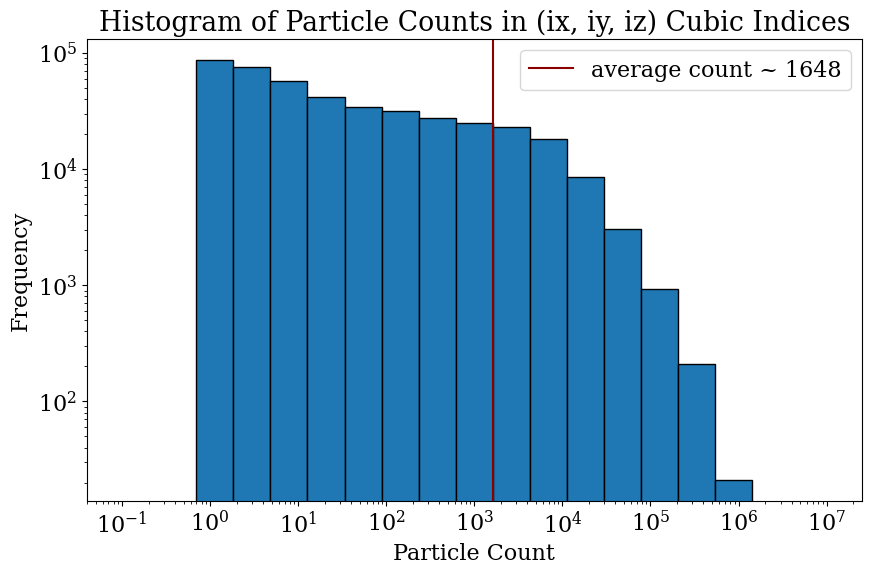

In [8]:
plt.figure(figsize=(10,6))
plt.hist(pandas_counts_df['particle_count'], bins=np.logspace(-1, 7, 20), edgecolor='black')
plt.axvline(x=np.average(pandas_counts_df['particle_count']), color = 'darkred',label = 'average count ~ '+str(int(np.average(pandas_counts_df['particle_count']))))
plt.title("Histogram of Particle Counts in (ix, iy, iz) Cubic Indices")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Particle Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [9]:
%%time
#subhalo table
#subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_trim.parquet.snappy'
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_trim_cubic_indexed.parquet.snappy'
subdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(subname)

#adding a column for the subhalo id
#subdf = subdf.withColumn("sub_id", F.monotonically_increasing_id())
#windowSpec = W.orderBy("sub_id")
#subdf = subdf.withColumn("sub_id", F.row_number().over(windowSpec) - 1)

subdf.limit(4).toPandas()
#subdf.describe().toPandas().T 

CPU times: user 5.96 ms, sys: 6.59 ms, total: 12.5 ms
Wall time: 481 ms


,sub_px,sub_py,sub_pz,sub_vx,sub_vy,sub_vz,sub_mass,sub_id,sub_ix,sub_iy,sub_iz
0,67181.007812,61138.191406,42513.519531,452.917145,-174.961197,-142.420242,2.901622e+10,65703,32,29,20
1,84640.750000,147412.468750,118282.007812,-270.519501,-185.522858,-55.987225,3.058682e+10,65704,41,71,57
2,58249.507812,68215.625000,9341.970703,-264.713196,-46.467815,-129.238602,2.632512e+10,65705,28,33,4
3,122429.289062,76214.148438,180472.734375,396.254089,142.365814,412.545654,2.951307e+10,65706,59,37,88


In [18]:
##changing the column name for cross joining
#subdf = subdf.withColumnRenamed("px", "sub_px")
#subdf = subdf.withColumnRenamed("py", "sub_py")
#subdf = subdf.withColumnRenamed("pz", "sub_pz")
#subdf = subdf.withColumnRenamed("vx", "sub_vx")
#subdf = subdf.withColumnRenamed("vy", "sub_vy")
#subdf = subdf.withColumnRenamed("vz", "sub_vz")
#subdf = subdf.withColumnRenamed("mass", "sub_mass")

##dividing the data into 100*100*100 boxes and adding the column for the box id
#subdf = subdf.withColumn("sub_ix", floor(F.col("sub_px") / (box_size/100)).cast('int'))
#subdf = subdf.withColumn("sub_iy", floor(F.col("sub_py") / (box_size/100)).cast('int'))
#subdf = subdf.withColumn("sub_iz", floor(F.col("sub_pz") / (box_size/100)).cast('int'))
#
#outname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/subhalo_trim_cubic_indexed.parquet.snappy'
#subdf.write.option("compression", "snappy").mode("overwrite").save(outname)
#subdf.toPandas().head()

,sub_px,sub_py,sub_pz,sub_vx,sub_vy,sub_vz,sub_mass,sub_id,sub_ix,sub_iy,sub_iz
0,99173.578125,40274.546875,107897.390625,-67.104362,-151.330200,167.907593,3.492153e+11,103713,48,19,52
1,120705.281250,69941.101562,157908.031250,269.752045,-320.683807,128.344238,3.287442e+11,103714,58,34,77
2,204545.296875,170294.812500,87957.867188,363.489685,148.479889,-54.548824,3.453248e+11,103715,99,83,42
3,173194.890625,158155.453125,162955.359375,83.774239,-126.974121,218.970139,3.937560e+11,103716,84,77,79
4,34154.796875,35974.179688,149377.250000,559.149902,597.246765,-471.297150,3.869574e+11,103717,16,17,72


# 2. Saving the particle data within the 50kpc spheres centered at each subhalo

In [ ]:
#direct distance square calculation
radius_sq = (50*h)**2 #50kpc aperture size
id_size = 100 #number of boxes

#broad casting the subhalo table to the all workers
broadcast_subdf = F.broadcast(subdf)

# Step 1: Coarse filtering by grid indices considering the periodic boundary
filtered_df = rawdf.crossJoin(broadcast_subdf).filter(
    (F.least(F.abs(F.col("ix") - F.col("sub_ix")), id_size - F.abs(F.col("ix") - F.col("sub_ix")) ) <= 1) &
    (F.least(F.abs(F.col("iy") - F.col("sub_iy")), id_size - F.abs(F.col("iy") - F.col("sub_iy")) ) <= 1) &
    (F.least(F.abs(F.col("iz") - F.col("sub_iz")), id_size - F.abs(F.col("iz") - F.col("sub_iz")) ) <= 1)
)

filtered_df = filtered_df.withColumn("dist_cent_sq", F.pow(F.least(F.abs(F.col("px") - F.col("sub_px")), box_size - F.abs(F.col("px") - F.col("sub_px"))), 2) +
                                                     F.pow(F.least(F.abs(F.col("py") - F.col("sub_py")), box_size - F.abs(F.col("py") - F.col("sub_py"))), 2) +
                                                     F.pow(F.least(F.abs(F.col("pz") - F.col("sub_pz")), box_size - F.abs(F.col("pz") - F.col("sub_pz"))), 2))

# Step 2: Fine filtering by distance calculation considering the periodic boundary
filtered_df = filtered_df.filter(
    (F.col("dist_cent_sq")) < radius_sq
)

# Select relevant columns (including subhalo_id for identification)
result_df = filtered_df.select("sub_id", "px", "py", "pz", "vx", "vy", "vz", "mass", "dist_cent_sq")

subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'
result_df.write.option("compression", "snappy").mode("overwrite").partitionBy("sub_id").parquet(subname)

In [7]:
#Checking the data
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'
df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 10000)
df_filtered.describe().toPandas()

,summary,px,py,pz,vx,vy,vz,mass,dist_cent_sq,sub_id
0,count,160,160,160,160,160,160,160,160,160
1,mean,86539.98217092815,115001.8123021865,144899.63376864442,-173.17213001875004,-162.7695493062501,201.53382877500002,5.594609641875001E-4,52.507032744363826,10000.0
2,stddev,4.3586223280873195,3.330779277000689,4.676035647780895,39.405089898886125,39.32917348856376,38.71986463333312,1.4510780084495814E-4,133.96340006846228,0.0
3,min,86517.54089495828,114987.06916561146,144874.48056289784,-298.88245,-250.64078,100.80679,2.5858832E-4,0.3857580077748698,10000
4,max,86558.38979516154,115009.8895705654,144911.07695180256,-54.3939,-47.9957,280.2506,8.7464123E-4,1050.5479423833408,10000


# 3. Calculating stellar velocity dispersion

We measure the stellar velocity dispersion of ~10$^5$ subhalos. We first select stellar particles within subhalo-centered spheres with a certain radius. We then calculate the mass-weighted stellar velocity dispersion based on the 3D velocity of selected stellar particles. 

### $M = \Sigma m_i $
### $\overline{v_x} = \frac{\Sigma m_i v_{i,x}}{M}$, $\, \overline{v_y} = \frac{\Sigma m_i v_{i,y}}{M}$, $\, \overline{v_z} = \frac{\Sigma m_i v_{i,z}}{M}$ 
### $\sigma_x^2 = \frac{\Sigma m_i (v_{i,x} - \overline{v_{x}})^2}{M}$, $\, \sigma_y^2 = \frac{\Sigma m_i (v_{i,y} - \overline{v_{y}})^2}{M}$, $\, \sigma_z^2 = \frac{\Sigma m_i (v_{i,z} - \overline{v_{z}})^2}{M}$
### $\therefore \sigma_{3D} = \sqrt{\sigma_x^2 + \sigma_y^2 + \sigma_z^2}$
We repeat the above calculation for six different radii (3, 5, 10, 20, 30, and 50 kpc).

In [4]:
subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/extracted_region_240918.parquet.snappy'

df = spark.read.parquet(subname)

df_filtered = df.filter(df.sub_id == 0)
df_filtered.describe().toPandas()

24/10/15 16:06:27 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 524288000 bytes). This may impact query planning performance.


,summary,px,py,pz,vx,vy,vz,mass,dist_cent_sq,sub_id
0,count,140,140,140,140,140,140,140,140,140
1,mean,41840.652056403436,49050.240491958146,146618.59384127078,491.1804762142857,2141.1263542857128,-734.4352684999993,5.289361012142856E-4,33.778025427646135,0.0
2,stddev,3.434179745897391,2.646253888959987,3.8308437191442546,47.42457028605087,43.16277394559926,46.21973330251511,1.3347494347952017E-4,69.45086123003283,0.0
3,min,41821.05056670708,49042.46942823968,146605.40289966715,330.69318,2015.9958,-865.76483,2.9745823E-4,2.034020586918334E-7,0
4,max,41854.11205584526,49061.58165936835,146634.89777236278,636.5443,2252.1292,-622.19794,8.7916595E-4,445.53822808873207,0


In [5]:
subhalo_count = df.select("sub_id").distinct().count()
print(f"Number of distinct subhalo IDs: {subhalo_count}")

Number of distinct subhalo IDs: 104290


In [6]:
%%time
from pyspark.sql import Window as W
import pyspark.sql.functions as F

# Define subhalo window for partitioning by "sub_id"
subhalo_window = W.partitionBy("sub_id")

# Initial weighted velocity and dispersion calculations for all particles
df = df.withColumn("vx_weighted", F.col("mass") * F.col("vx"))
df = df.withColumn("vy_weighted", F.col("mass") * F.col("vy"))
df = df.withColumn("vz_weighted", F.col("mass") * F.col("vz"))

df = df.withColumn("mass_sum", F.sum("mass").over(subhalo_window))

df = df.withColumn("vx_avg", F.sum("vx_weighted").over(subhalo_window) / F.col("mass_sum"))
df = df.withColumn("vy_avg", F.sum("vy_weighted").over(subhalo_window) / F.col("mass_sum"))
df = df.withColumn("vz_avg", F.sum("vz_weighted").over(subhalo_window) / F.col("mass_sum"))

df = df.withColumn("vx_disp", (F.col("vx") - F.col("vx_avg"))**2)
df = df.withColumn("vy_disp", (F.col("vy") - F.col("vy_avg"))**2)
df = df.withColumn("vz_disp", (F.col("vz") - F.col("vz_avg"))**2)

df = df.withColumn("dispersion_weighted", F.col("mass") * (F.col("vx_disp") + F.col("vy_disp") + F.col("vz_disp")))

# First aperture (50 kpc)
velocity_dispersion_df = df.groupBy("sub_id").agg(
    (F.sqrt(F.sum("dispersion_weighted") / F.sum("mass"))).alias("mass_weighted_velocity_dispersion_50")
)

# Iterate through different apertures (30, 20, 10, 5, 3 kpc)
for apert in [30, 20, 10, 5, 3]:
    # Reset the DataFrame for each aperture
    distance_limit = (apert * h) ** 2
    df_aperture = df.filter(F.col("dist_cent_sq") <= distance_limit)

    df_aperture = df_aperture.withColumn("mass_sum", F.sum("mass").over(subhalo_window))
    
    df_aperture = df_aperture.withColumn("vx_avg", F.sum("vx_weighted").over(subhalo_window) / F.col("mass_sum"))
    df_aperture = df_aperture.withColumn("vy_avg", F.sum("vy_weighted").over(subhalo_window) / F.col("mass_sum"))
    df_aperture = df_aperture.withColumn("vz_avg", F.sum("vz_weighted").over(subhalo_window) / F.col("mass_sum"))
    
    df_aperture = df_aperture.withColumn("vx_disp", (F.col("vx") - F.col("vx_avg"))**2)
    df_aperture = df_aperture.withColumn("vy_disp", (F.col("vy") - F.col("vy_avg"))**2)
    df_aperture = df_aperture.withColumn("vz_disp", (F.col("vz") - F.col("vz_avg"))**2)
    
    df_aperture = df_aperture.withColumn("dispersion_weighted", F.col("mass") * (F.col("vx_disp") + F.col("vy_disp") + F.col("vz_disp")))

    velocity_dispersion_tmp = df_aperture.groupBy("sub_id").agg(
        (F.sqrt(F.sum("dispersion_weighted") / F.sum("mass"))).alias("mass_weighted_velocity_dispersion_" + str(apert))
    )
    
    # Combine the results for each aperture
    velocity_dispersion_df = velocity_dispersion_df.join(velocity_dispersion_tmp, "sub_id")

# Show the final combined DataFrame
velocity_dispersion_df.show()

+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|sub_id|mass_weighted_velocity_dispersion_50|mass_weighted_velocity_dispersion_30|mass_weighted_velocity_dispersion_20|mass_weighted_velocity_dispersion_10|mass_weighted_velocity_dispersion_5|mass_weighted_velocity_dispersion_3|
+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|   148|                   60.35325051104238|                   61.38776748254439|                   62.38146856184683|                   65.64963521122424|                  70.08732553224417|                  68.72902382988421|
|   463|                   350.0666538753182|                   174.3795225514606|  

In [8]:
sub_id_to_find = 10000
filtered_df = velocity_dispersion_df.filter(velocity_dispersion_df["sub_id"] == sub_id_to_find)
filtered_df.show()

+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
|sub_id|mass_weighted_velocity_dispersion_50|mass_weighted_velocity_dispersion_30|mass_weighted_velocity_dispersion_20|mass_weighted_velocity_dispersion_10|mass_weighted_velocity_dispersion_5|mass_weighted_velocity_dispersion_3|
+------+------------------------------------+------------------------------------+------------------------------------+------------------------------------+-----------------------------------+-----------------------------------+
| 10000|                   67.54407056722899|                   67.25768361639068|                   67.79019897412951|                   68.88366311763865|                  72.93970174994601|                  73.40487757132327|
+------+------------------------------------+------------------------------------+--

In [10]:
%%time
#saving the divided data 
file_num = [0, 1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 9e4, 104290]
for i in range(len(file_num) - 1):
    #print(i)
    subname = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/vdisp_241015/vdisp_241015_'+str(int(file_num[i]))+'_snappy.parquet'
    filtered_df = velocity_dispersion_df.filter((velocity_dispersion_df["sub_id"] >= file_num[i]) &
                                                (velocity_dispersion_df["sub_id"] < file_num[i+1])
                                               )
    filtered_df.write.mode("overwrite").parquet(subname, compression="snappy")

# 4. One to one Comparison with the table value
Table values are based on the stellar particles with the subhalo membership.
However, Hadoop calculated the velocity dispersion based on all stellar particles in the spheres. There is a slight difference in their values.

In [11]:
parquet_files_path = 'hdfs://sohnic:54310/data/TNG300/snap99/parquet/vdisp_241015/vdisp_241015_*.parquet'

# Read all matching files with the glob pattern
combined_df = spark.read.parquet(parquet_files_path)
combined_df = combined_df.dropDuplicates(['sub_id'])

# Show the schema and some data
combined_df.printSchema()
combined_df.describe().toPandas().T 

root
 |-- sub_id: integer (nullable = true)
 |-- mass_weighted_velocity_dispersion_50: double (nullable = true)
 |-- mass_weighted_velocity_dispersion_30: double (nullable = true)
 |-- mass_weighted_velocity_dispersion_20: double (nullable = true)
 |-- mass_weighted_velocity_dispersion_10: double (nullable = true)
 |-- mass_weighted_velocity_dispersion_5: double (nullable = true)
 |-- mass_weighted_velocity_dispersion_3: double (nullable = true)



,0,1,2,3,4
summary,count,mean,stddev,min,max
sub_id,104091,52103.52281177047,30086.703627764902,1,104289
mass_weighted_velocity_dispersion_50,104091,185.9876199618823,128.6575178067266,21.957899424477866,2392.266684886717
mass_weighted_velocity_dispersion_30,104091,167.84252411043929,101.64578650864576,19.87661397937459,1857.6435759726703
mass_weighted_velocity_dispersion_20,104091,158.38277499817374,86.37580584916851,19.956470008300446,1701.613355142468
mass_weighted_velocity_dispersion_10,104091,149.21358696335736,71.24236698720489,20.02521070504284,1495.4053150987802
mass_weighted_velocity_dispersion_5,104091,143.4145344308102,63.444539456799255,17.855750815682526,1058.9359034900733
mass_weighted_velocity_dispersion_3,104091,136.48214189589152,59.1861317271201,0.0,760.6326977583898


In [12]:
#subhalo table (~few seconds)
t300 = pd.read_csv('./TNG300_quiescent_subhalos.csv')
print(len(t300))
t300.head()

104290


,Unnamed: 0,ID,GrNr,Posx,Posy,Posz,CMx,CMy,CMz,Velx,...,vdisp_dm_pos_sph_rh_z_bi,vdisp_dm_pos_sph_rh_z_mweight,vdisp_dm_pos_sph_rh_z_lweight,vdisp_dm_pos_sph_rh_3d_std,vdisp_dm_pos_sph_rh_3d_bi,vdisp_dm_pos_sph_rh_3d_mweight,vdisp_dm_pos_sph_rh_3d_lweight,central,quiescent,edge
0,1,394,0,41839.938,49050.410,146618.52,41841.720,49049.500,146618.42,505.39545,...,56.230135,0.0,0.0,93.595999,94.790011,0.0,0.0,0,1,1
1,2,403,0,45247.900,51453.363,145176.55,45247.434,51453.367,145176.25,484.58800,...,61.195377,0.0,0.0,108.910434,110.497556,0.0,0.0,0,1,1
2,3,421,0,43345.830,50114.844,148136.55,43344.582,50116.066,148136.56,2266.76460,...,57.704420,0.0,0.0,100.625152,102.887322,0.0,0.0,0,1,1
3,4,423,0,43848.816,51581.773,145344.84,43851.332,51581.540,145348.30,-1288.37480,...,49.692601,0.0,0.0,90.353464,92.019996,0.0,0.0,0,1,1
4,5,447,0,44503.348,47543.660,146977.92,44503.926,47543.100,146978.66,-157.55678,...,57.704970,0.0,0.0,102.185058,104.080819,0.0,0.0,0,1,1


In [13]:
# sorting the pyspark dataframe based on sub_id & caching the data
sorted_combined_df = combined_df.orderBy('sub_id')
sorted_combined_df.cache()

df_spark = pd.DataFrame()
df_spark['sig'] = sorted_combined_df.select('mass_weighted_velocity_dispersion_20').toPandas()
df_spark['sub_id'] = sorted_combined_df.select('sub_id').toPandas()

In [14]:
df_csv = pd.DataFrame()
df_csv['sig_sohn'] = t300['vdisp_star_pos_sph_20kpc_3d_mweight']
df_csv['sub_id'] = range(104290) #similar to the sub_id assignment from 'hdf_to_parquet.ipynb'
df_csv.head(10)

,sig_sohn,sub_id
0,78.503645,0
1,84.243082,1
2,71.280738,2
3,65.791358,3
4,80.627809,4
5,81.150709,5
6,74.807477,6
7,80.576113,7
8,86.694709,8
9,87.394604,9


In [15]:
result_df = pd.merge(df_spark, df_csv, on="sub_id", how="inner", suffixes=('_spark', '_csv'))
result_df.tail(10)

,sig,sub_id,sig_sohn
104081,603.539655,104280,603.539657
104082,673.180966,104281,673.180973
104083,839.023318,104282,839.023316
104084,643.511856,104283,643.511853
104085,649.130782,104284,649.130778
104086,643.236854,104285,643.236854
104087,586.392210,104286,586.392206
104088,600.922044,104287,600.922048
104089,686.326629,104288,686.326628
104090,770.483736,104289,770.483744


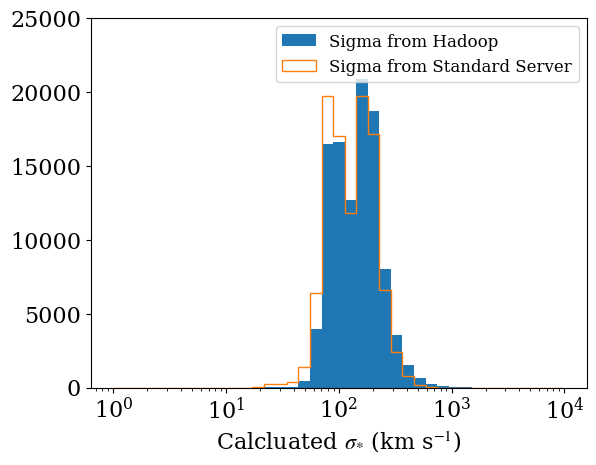

In [22]:
#histogram
bins = np.logspace(0, 4, 40)
plt.hist(result_df['sig'], bins = bins, label = 'Sigma from Hadoop')
plt.hist(result_df['sig_sohn'], bins = bins, histtype = 'step', label = 'Sigma from Standard Server')
plt.xlabel(r'Calcluated $\sigma_{*}$ (km s$^{-1}$)')
plt.legend(fontsize = 12)
plt.ylim(-10, 25000)
plt.xscale('log')

In [24]:
residuals = result_df['sig_sohn'] - result_df['sig']

# Calculate standard deviation (sigma) of residuals
sigma = np.std(residuals)

# Find the points that deviate more than 1 sigma
#outliers = np.abs(residuals) > sigma
outliers = np.abs(residuals) > 50

# Count the number of outliers
num_outliers = np.sum(outliers)
#print(len(residuals))
#print(num_outliers)
print('Ratio of outliers = ' + str(num_outliers / len(residuals)))

Ratio of outliers = 0.0742235159619948


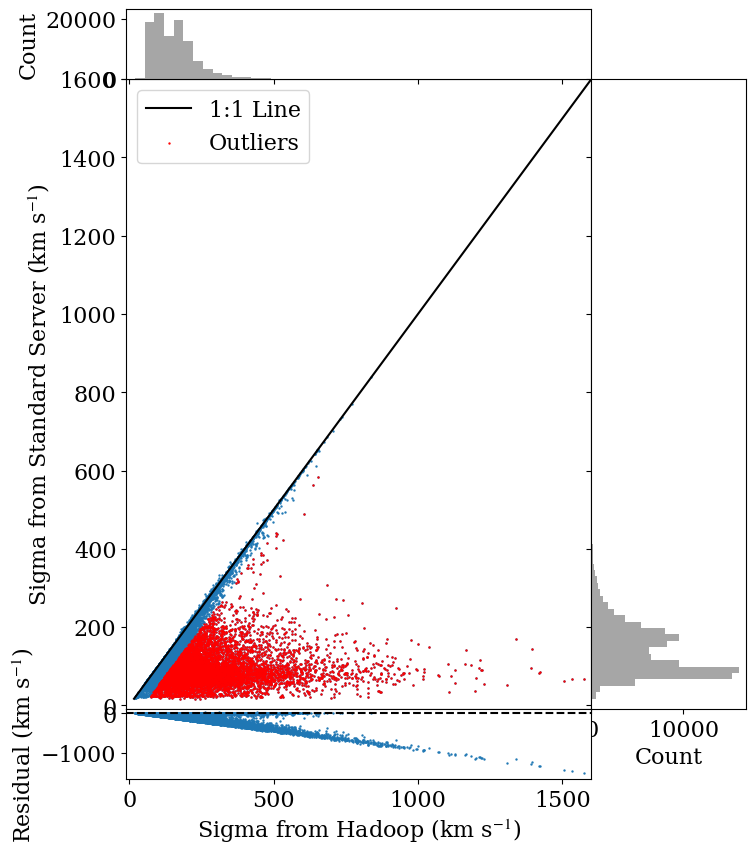

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

# Create figure with gridspec
fig = plt.figure(figsize=(8, 10))  # Figure size remains the same
gs = gridspec.GridSpec(5, 4, hspace=0, wspace=0, height_ratios=[1, 3, 3, 3, 1])  # Adjust height ratios, reduce rows to 5

# Scatter plot (1:1 plot)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])  # Take 3 rows for the scatter plot
ax_scatter.plot(np.linspace(min(result_df['sig_sohn']), 1600, 100),
                np.linspace(min(result_df['sig_sohn']), 1600, 100), 
                color='k', label="1:1 Line")
ax_scatter.scatter(result_df['sig'], result_df['sig_sohn'], s=0.5)
plt.scatter(result_df[outliers]['sig'], result_df[outliers]['sig_sohn'], color='red', s=0.5, label='Outliers')
plt.legend()

ax_scatter.set_ylabel(r'Sigma from Standard Server (km s$^{-1}$)')
# Set equal aspect ratio
ax_scatter.set_xlim(-10, 1600)
ax_scatter.set_ylim(-10, 1600)

# Histograms for X-axis (top panel)
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histx.hist(result_df['sig'], bins=50, color='gray', alpha=0.7)
ax_histx.set_ylabel('Count')

# Remove x-axis ticks and labels from the upper histogram
ax_histx.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)

# Histograms for Y-axis (right panel)
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)
ax_histy.hist(result_df['sig_sohn'], bins=50, color='gray', alpha=0.7, orientation='horizontal')
ax_histy.set_xlabel('Count')

# Remove y-axis ticks and labels from the right histogram
ax_histy.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

# Residual plot (difference between sig_sohn and sig, i.e., residuals)
residuals = result_df['sig_sohn'] - result_df['sig']
ax_residual = fig.add_subplot(gs[4, 0:3], sharex=ax_scatter)
ax_residual.scatter(result_df['sig'], residuals, s=0.5)
ax_residual.axhline(0, color='k', linestyle='--')  # Line at y=0 for reference

# Set labels for residual plot
ax_residual.set_xlabel(r'Sigma from Hadoop (km s$^{-1}$)')
ax_residual.set_ylabel('Residual (km s$^{-1}$)')

# Remove ticks for the scatter plot's x-axis to avoid redundancy
ax_scatter.tick_params(axis='x', which='both', bottom=False, labelbottom=False)